# Flag hits likely due to abundance differences

In [1]:
# Imports
import polars as pl
from tqdm import tqdm
import plotnine as plotnine

In [20]:
# Paths
metrics_dir = "/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B7B8_1percent_updatedmeta"
prof_dir = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles"
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")
metrics_wtvar = pl.read_csv(f"{metrics_dir}/metrics_summary.csv")
thresh = 3  # previously 10
min_class_num = 2

In [4]:
test = pl.scan_parquet(
    f"{prof_dir}/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
)
meta_cols = [i for i in test.columns if "Metadata" in i]

meta = test.select(meta_cols).collect()
meta

Metadata_plate_map_name,Metadata_well_position,Metadata_source_plate,Metadata_source_well,Metadata_source_numb,Metadata_dest_plate,Metadata_dest_well,Metadata_dest_numb,Metadata_imaging_well,Metadata_imaging_plate_R1,Metadata_imaging_plate_R2,Metadata_orf_id_wt,Metadata_ccsb_mutation_id,Metadata_nt_change_cdna,Metadata_aa_change,Metadata_allele_set,Metadata_imaging_plate,Metadata_batch1,Metadata_batch2,Metadata_clone_ID,Metadata_hgmd_ID,Metadata_clinvar_allele_ID,Metadata_clinvar_clinical_significance,Metadata_vector,Metadata_notes,Metadata_plate,Metadata_quad,Metadata_c96,Metadata_r96,Metadata_r384,Metadata_c384,Metadata_r384_letter,Metadata_Well,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_ObjectNumber,Metadata_Plate,Metadata_CellID,Metadata_symbol,Metadata_gene_allele,Metadata_node_type
str,str,str,str,f64,str,str,i64,str,str,str,f64,f64,str,str,i64,i64,i64,i64,f64,f64,f64,f64,f64,str,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,i64,i64,str,str,str,str,str
"""B7A1R1_P1""","""C24""","""VUSmut_GDEh05""","""H02""",16.0,"""FVrry_P01_Q02""","""B12""",90,"""C24""","""B7A1R1_P1""","""B8A1R2_P1""",9634.0,216880.0,"""169C>G""","""Gln57Glu""",1,1,7,8,null,null,null,null,527.0,"""""",1,2,12,2,3,24,"""C""","""C24""",469822178,648,30,30,30,"""2024_01_17_B7A…","""2024_01_17_B7A…","""CLDN19""","""CLDN19_Arg200G…","""allele"""
"""B7A1R1_P1""","""P11""","""VUSmut_GDEh12""","""C09""",67.0,"""FVrry_P01_Q03""","""H06""",48,"""P11""","""B7A1R1_P1""","""B8A1R2_P1""",268.0,715.0,"""1208G>T""","""Ser403Ile""",1,1,7,8,null,null,null,null,527.0,"""""",1,3,6,8,16,11,"""P""","""P11""",3267680531,3331,14,14,14,"""2024_01_17_B7A…","""2024_01_17_B7A…","""CTNNA3""","""CTNNA3_Val94As…","""allele"""
"""B7A1R1_P1""","""P11""","""VUSmut_GDEh12""","""C09""",67.0,"""FVrry_P01_Q03""","""H06""",48,"""P11""","""B7A1R1_P1""","""B8A1R2_P1""",268.0,715.0,"""1208G>T""","""Ser403Ile""",1,1,7,8,null,null,null,null,527.0,"""""",1,3,6,8,16,11,"""P""","""P11""",3267680531,3331,13,13,13,"""2024_01_17_B7A…","""2024_01_17_B7A…","""CTNNA3""","""CTNNA3_Val94As…","""allele"""
"""B7A1R1_P1""","""P11""","""VUSmut_GDEh12""","""C09""",67.0,"""FVrry_P01_Q03""","""H06""",48,"""P11""","""B7A1R1_P1""","""B8A1R2_P1""",268.0,715.0,"""1208G>T""","""Ser403Ile""",1,1,7,8,null,null,null,null,527.0,"""""",1,3,6,8,16,11,"""P""","""P11""",3267680531,3331,12,12,12,"""2024_01_17_B7A…","""2024_01_17_B7A…","""CTNNA3""","""CTNNA3_Val94As…","""allele"""
"""B7A1R1_P1""","""P11""","""VUSmut_GDEh12""","""C09""",67.0,"""FVrry_P01_Q03""","""H06""",48,"""P11""","""B7A1R1_P1""","""B8A1R2_P1""",268.0,715.0,"""1208G>T""","""Ser403Ile""",1,1,7,8,null,null,null,null,527.0,"""""",1,3,6,8,16,11,"""P""","""P11""",3267680531,3331,11,11,11,"""2024_01_17_B7A…","""2024_01_17_B7A…","""CTNNA3""","""CTNNA3_Val94As…","""allele"""
"""B7A1R1_P1""","""P11""","""VUSmut_GDEh12""","""C09""",67.0,"""FVrry_P01_Q03""","""H06""",48,"""P11""","""B7A1R1_P1""","""B8A1R2_P1""",268.0,715.0,"""1208G>T""","""Ser403Ile""",1,1,7,8,null,null,null,null,527.0,"""""",1,3,6,8,16,11,"""P""","""P11""",3267680531,3331,10,10,10,"""2024_01_17_B7A…","""2024_01_17_B7A…","""CTNNA3""","""CTNNA3_Val94As…","""allele"""
"""B7A1R1_P1""","""P11""","""VUSmut_GDEh12""","""C09""",67.0,"""FVrry_P01_Q03""","""H06""",48,"""P11""","""B7A1R1_P1""","""B8A1R2_P1""",268.0,715.0,"""1208G>T""","""Ser403Ile""",1,1,7,8,null,null,null,null,527.0,"""""",1,3,6,8,16,11,"""P""","""P11""",3267680531,3331,8,8,8,"""2024_01_17_B7A…","""2024_01_17_B7A…","""CTNNA3""","""CTNNA3_Val94As…","""allele"""
"""B7A1R1_P1""","""P11""","""VUSmut_GDEh12""","""C09""",67.0,"""FVrry_P01_Q03""","""H06""",48,"""P11""","""B7A1R1_P1""","""B8A1R2_P1""",268.0,715.0,"""1208G>T""","""Ser403Ile""",1,1,7,8,null,null,null,null,527.0,"""""",1,3,6,8,16,11,"""P""","""P11""",3267680531,3331,7,7,7,"""2024_01_17_B7A…","""2024_01_17_B7A…","""CTNNA3""","""CTNNA3_Val94As…","""allele"""
"""B7A1R1_P1""","""P11""","""VUSmut_GDEh12""","""C09""",67.0,"""FV

In [5]:
# Filter profiles to only include cells from classifiers that passed filters
# Examine median intensity differences

In [6]:
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")

# Alleles must be mislocalized in both batches
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("Mislocalized")
).unique()

local_wtvar = local_wtvar.pivot(
    index=["allele_0", "Allele_set"],
    columns="Batch",
    values="Mislocalized",
).with_columns(
    ((pl.col("batch7") == 1) & (pl.col("batch8") == 1)).alias(
        "Mislocalized_both_batches"
    )
)

misloc_alleles = (
    local_wtvar
    # .filter(pl.col("Mislocalized_both_batches"))
    .select("allele_0")
    .to_series()
    .to_list()
)

misloc_wt = (
    local_wtvar
    # .filter(pl.col("Mislocalized_both_batches"))
    .with_columns(pl.col("allele_0").str.replace("_.*", "").alias("wt"))
    .select("wt")
    .to_series()
    .unique()
    .to_list()
)

all_alleles = misloc_alleles + misloc_wt

In [7]:
# Get individual classifiers
ind_class = metrics_df.filter(
    (~pl.col("Metadata_Control"))
    & (pl.col("Training_imbalance") < thresh)
    & (
        pl.col("allele_0").is_in(misloc_alleles)
        & (pl.col("Full_Classifier_ID").str.contains("true"))
    )
)

In [8]:
# Get meta features
b7_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)
b8_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)

cell_alleles = pl.concat([b7_alleles.collect(), b8_alleles.collect()])

In [9]:
b7_prof = pl.scan_parquet(
    f"{prof_dir}/2024_01_23_Batch_7/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)
b8_prof = pl.scan_parquet(
    f"{prof_dir}/2024_02_06_Batch_8/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)

gfp_int = [i for i in b7_prof.columns if "Cells_Intensity" in i]
gfp_int = ["Metadata_CellID"] + [i for i in gfp_int if "GFP" in i]

profiles = pl.concat([
    b7_prof.select(gfp_int).collect(),
    b8_prof.select(gfp_int).collect(),
])

# This method of joining ensures that only cells past filters are included in the abundance analysis
profiles = cell_alleles.join(profiles, on="Metadata_CellID", how="left")

In [10]:
well_profiles = (
    profiles.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in profiles.columns
        if not col.startswith("Metadata_")
    )
    .drop("Metadata_CellID")
    .unique()
)

In [11]:
import statsmodels.formula.api as smf


def lmm(fix_var: str, rand_var: str, reference: str, var: str, dat):
    # perform stat test
    model = smf.mixedlm(
        f"{fix_var} ~ C(Metadata_gene_allele, Treatment(reference='{reference}'))",
        data=dat,
        groups=dat[rand_var],
    )
    result = model.fit()

    # format results
    summary_df = pl.DataFrame(result.summary().tables[1][1:2])
    summary_df = summary_df.with_columns([
        pl.col(column).cast(pl.Float64).alias(column) for column in summary_df.columns
    ])

    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )

    return summary_df

Calculate the difference in intensity across wells using single-cell measurements. This approach suffers from pseudo-replication.

In [12]:
sc_abun_stats = []
for allele in tqdm(misloc_alleles):
    temp_class = ind_class.filter(pl.col("allele_0") == allele)
    temp_prof = profiles.filter(
        (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
        & (
            pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
            | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
        )
    )
    sc_abun_stats.append(
        lmm(
            "Cells_Intensity_MedianIntensity_GFP",
            "Metadata_Plate",
            allele.split("_")[0],
            allele,
            temp_prof.to_pandas(),
        )
    )

sc_abun_stats = pl.concat(sc_abun_stats, how="vertical")
sc_abun_stats = sc_abun_stats.rename({"z": "U2OS_Z"})

  0%|          | 0/471 [00:00<?, ?it/s]

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  0%|          | 1/471 [00:00<02:04,  3.77it/s]/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  1%|          | 3/471 [00:00<01:08,  6.87it/s]/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packag

In [13]:
sc_abun_stats.write_csv("../results/sc_abundance_changes.csv")

Calculate differences in abundance using well-aggregated profiles.

In [14]:
well_abun_stats = []
for allele in tqdm(misloc_alleles):
    temp_class = ind_class.filter(pl.col("allele_0") == allele)
    temp_prof = well_profiles.filter(
        (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
        & (
            pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
            | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
        )
    )
    well_abun_stats.append(
        lmm(
            "Cells_Intensity_MedianIntensity_GFP",
            "Metadata_Plate",
            allele.split("_")[0],
            allele,
            temp_prof.to_pandas(),
        )
    )

well_abun_stats = pl.concat(well_abun_stats, how="vertical")
well_abun_stats = well_abun_stats.rename({"z": "U2OS_Z"})
well_abun_stats.write_csv("../results/well_abundance_changes.csv")

  0%|          | 0/471 [00:00<?, ?it/s]/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  1%|          | 3/471 [00:00<00:15, 29.91it/s]/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/stats

In [15]:
# Compare to dual data
dual_abun = (
    pl.read_csv("../data/abundance_ppi_his3_edgotyping.tsv", separator="\t")
    .filter(pl.col("node_type") == "allele")
    .with_columns(
        pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
    )
    .select(["Variant", "z_abundance_change"])
    .filter(pl.col("z_abundance_change").is_not_null())
    .with_columns(pl.col("z_abundance_change").cast(pl.Float64))
    .rename({"z_abundance_change": "dual_Z"})
)
abun_dual_sc = sc_abun_stats.join(dual_abun, on="Variant", how="left").filter(
    pl.col("dual_Z").is_not_null()
)
abun_dual_well = well_abun_stats.join(dual_abun, on="Variant", how="left").filter(
    pl.col("dual_Z").is_not_null()
)

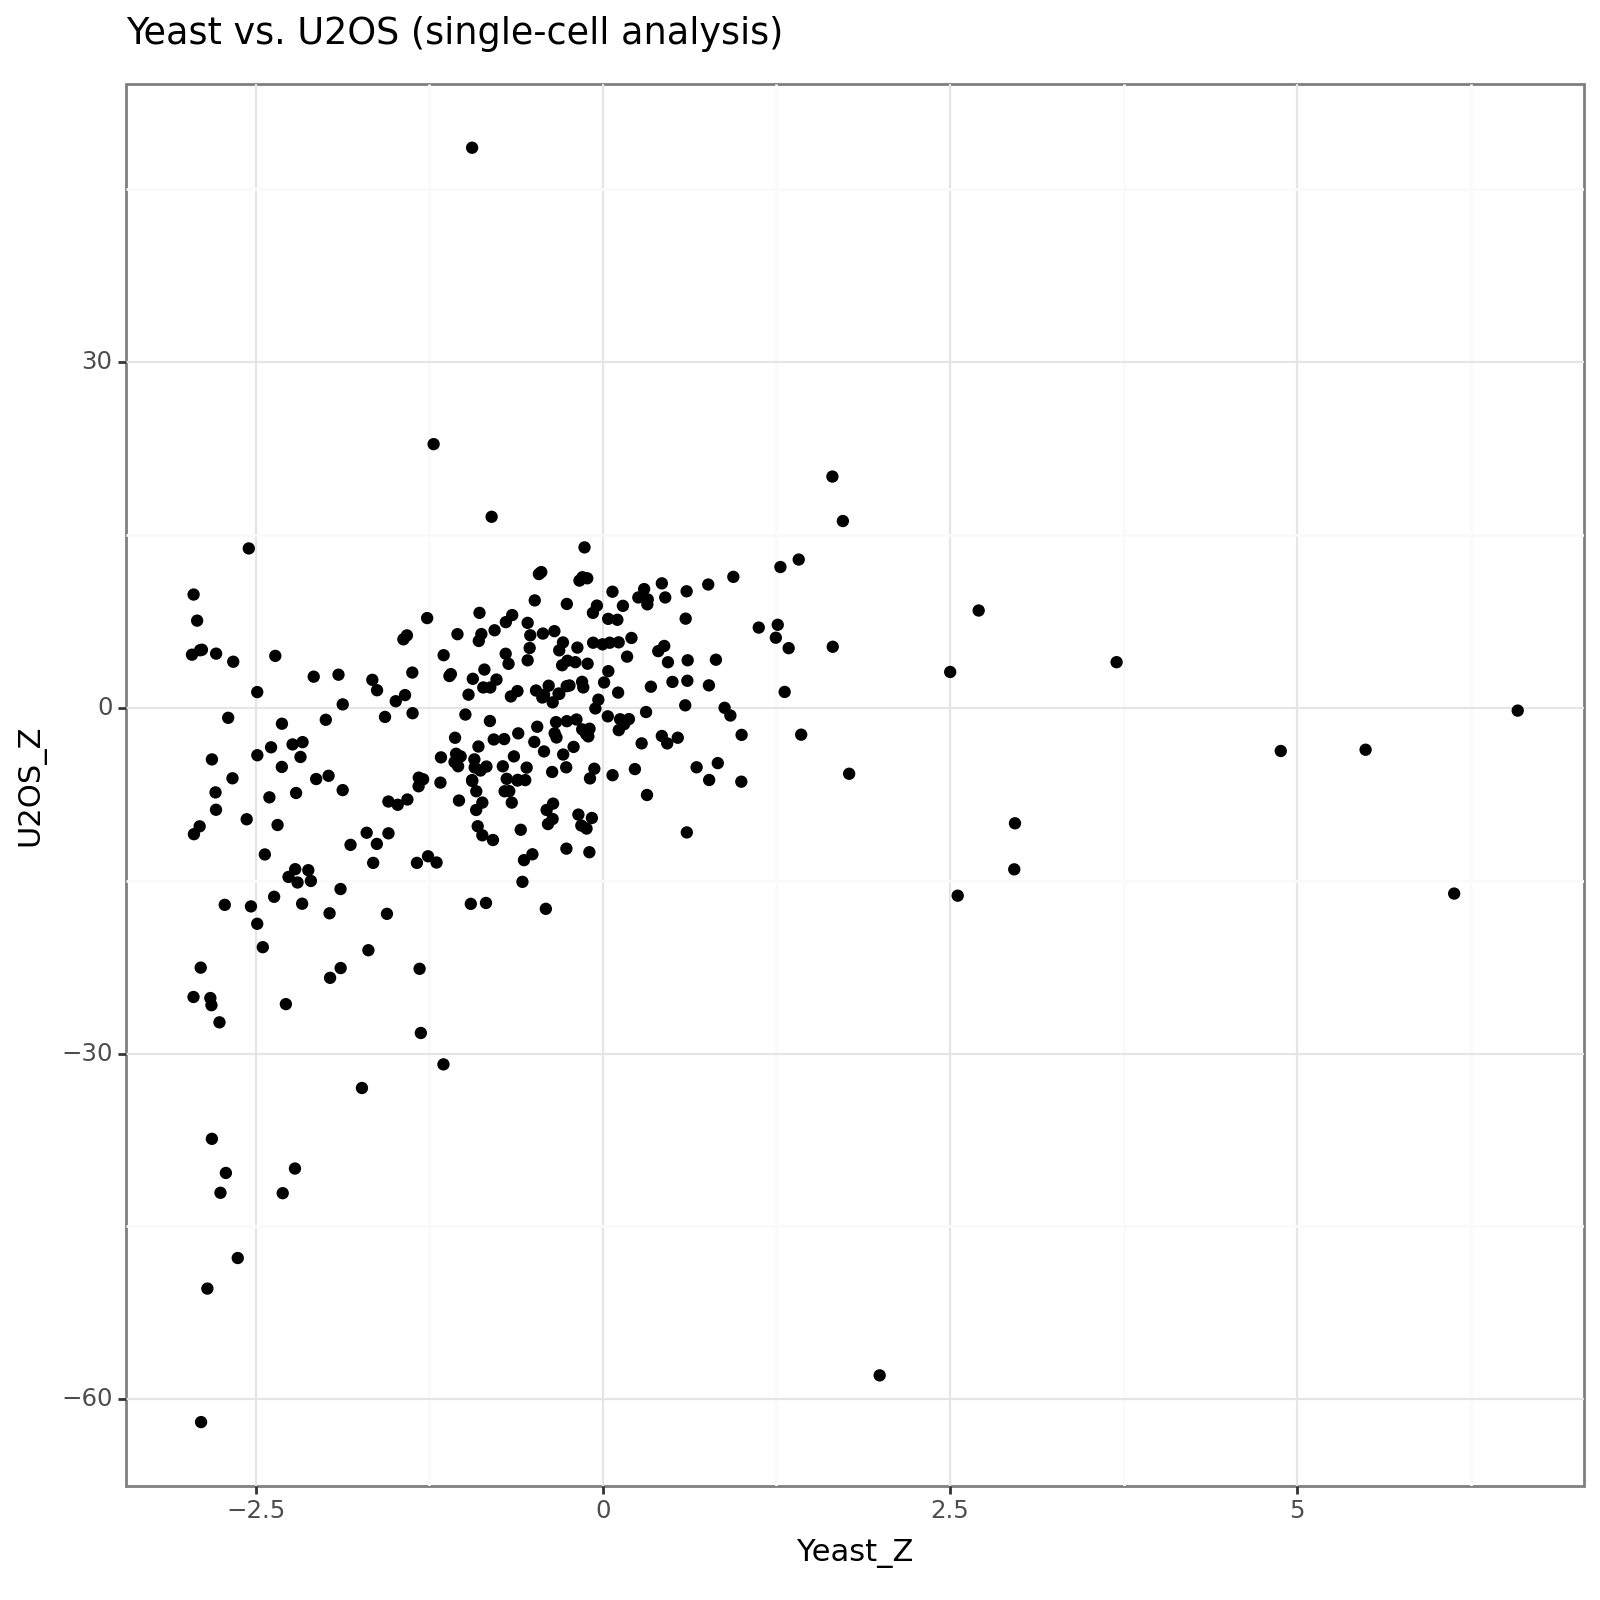

In [16]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_sc,
        aes(x="dual_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
    + labs(title="dual vs. U2OS (single-cell analysis)")
)
print(plot1)

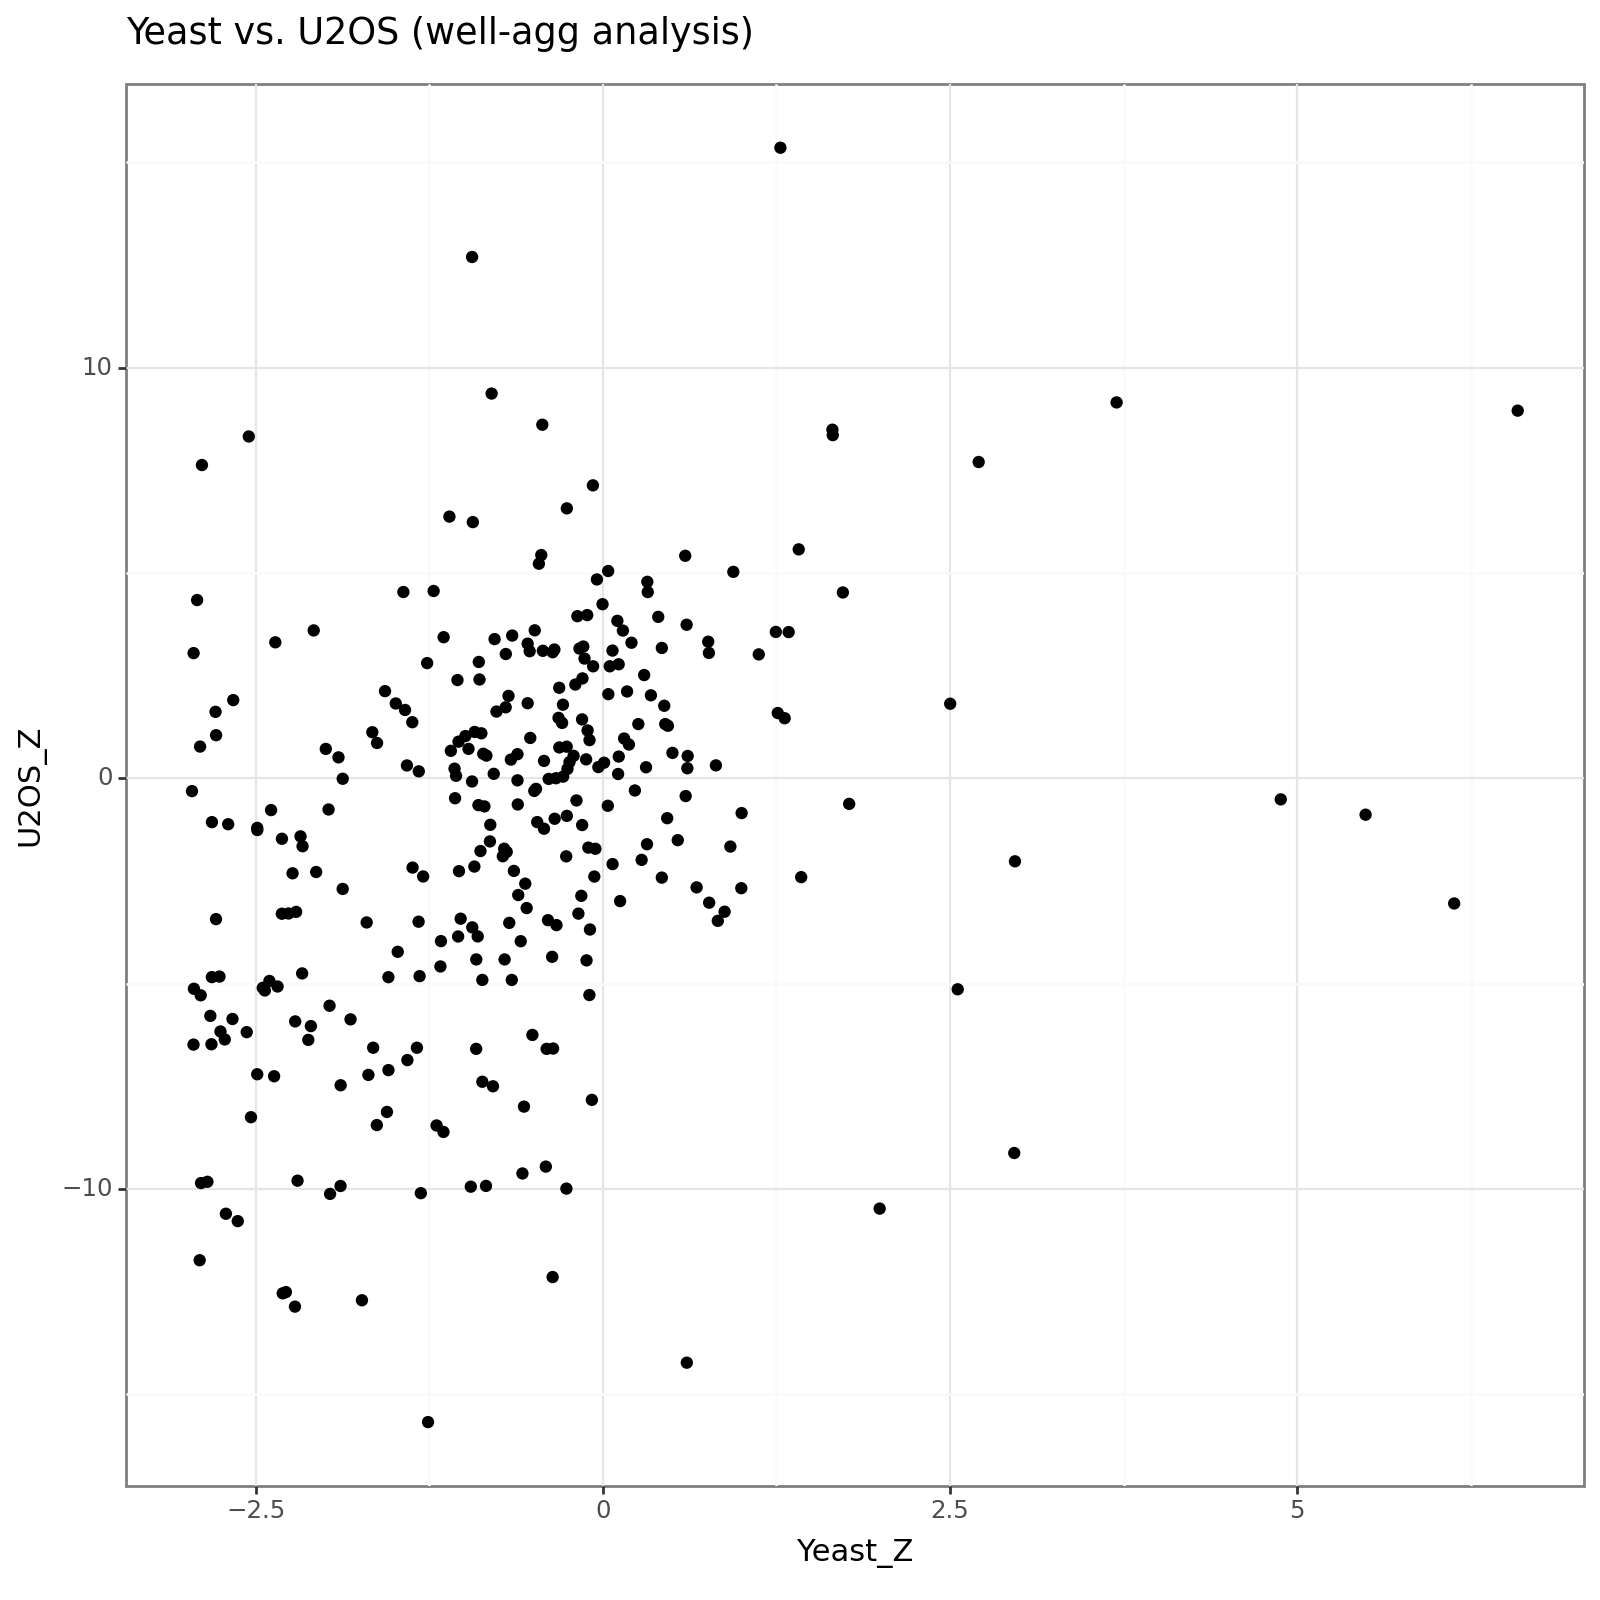

In [17]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_well,
        aes(x="dual_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
    + labs(title="dual vs. U2OS (well-agg analysis)")
)
print(plot1)

In [18]:
from scipy.stats import pearsonr

u2os_z = abun_dual_well["U2OS_Z"].to_numpy()
dual_z = abun_dual_well["dual_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, dual_z)

print("Well-agg stats: ")
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")


Well-agg stats: 
Pearson correlation coefficient: 0.34207201195222053
P-value: 9.639750102498583e-10


In [19]:
from scipy.stats import pearsonr

u2os_z = abun_dual_sc["U2OS_Z"].to_numpy()
dual_z = abun_dual_sc["dual_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, dual_z)

print("Single-cell stats: ")
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

Single-cell stats: 
Pearson correlation coefficient: 0.32056490693417244
P-value: 1.1409530313557542e-08


/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.


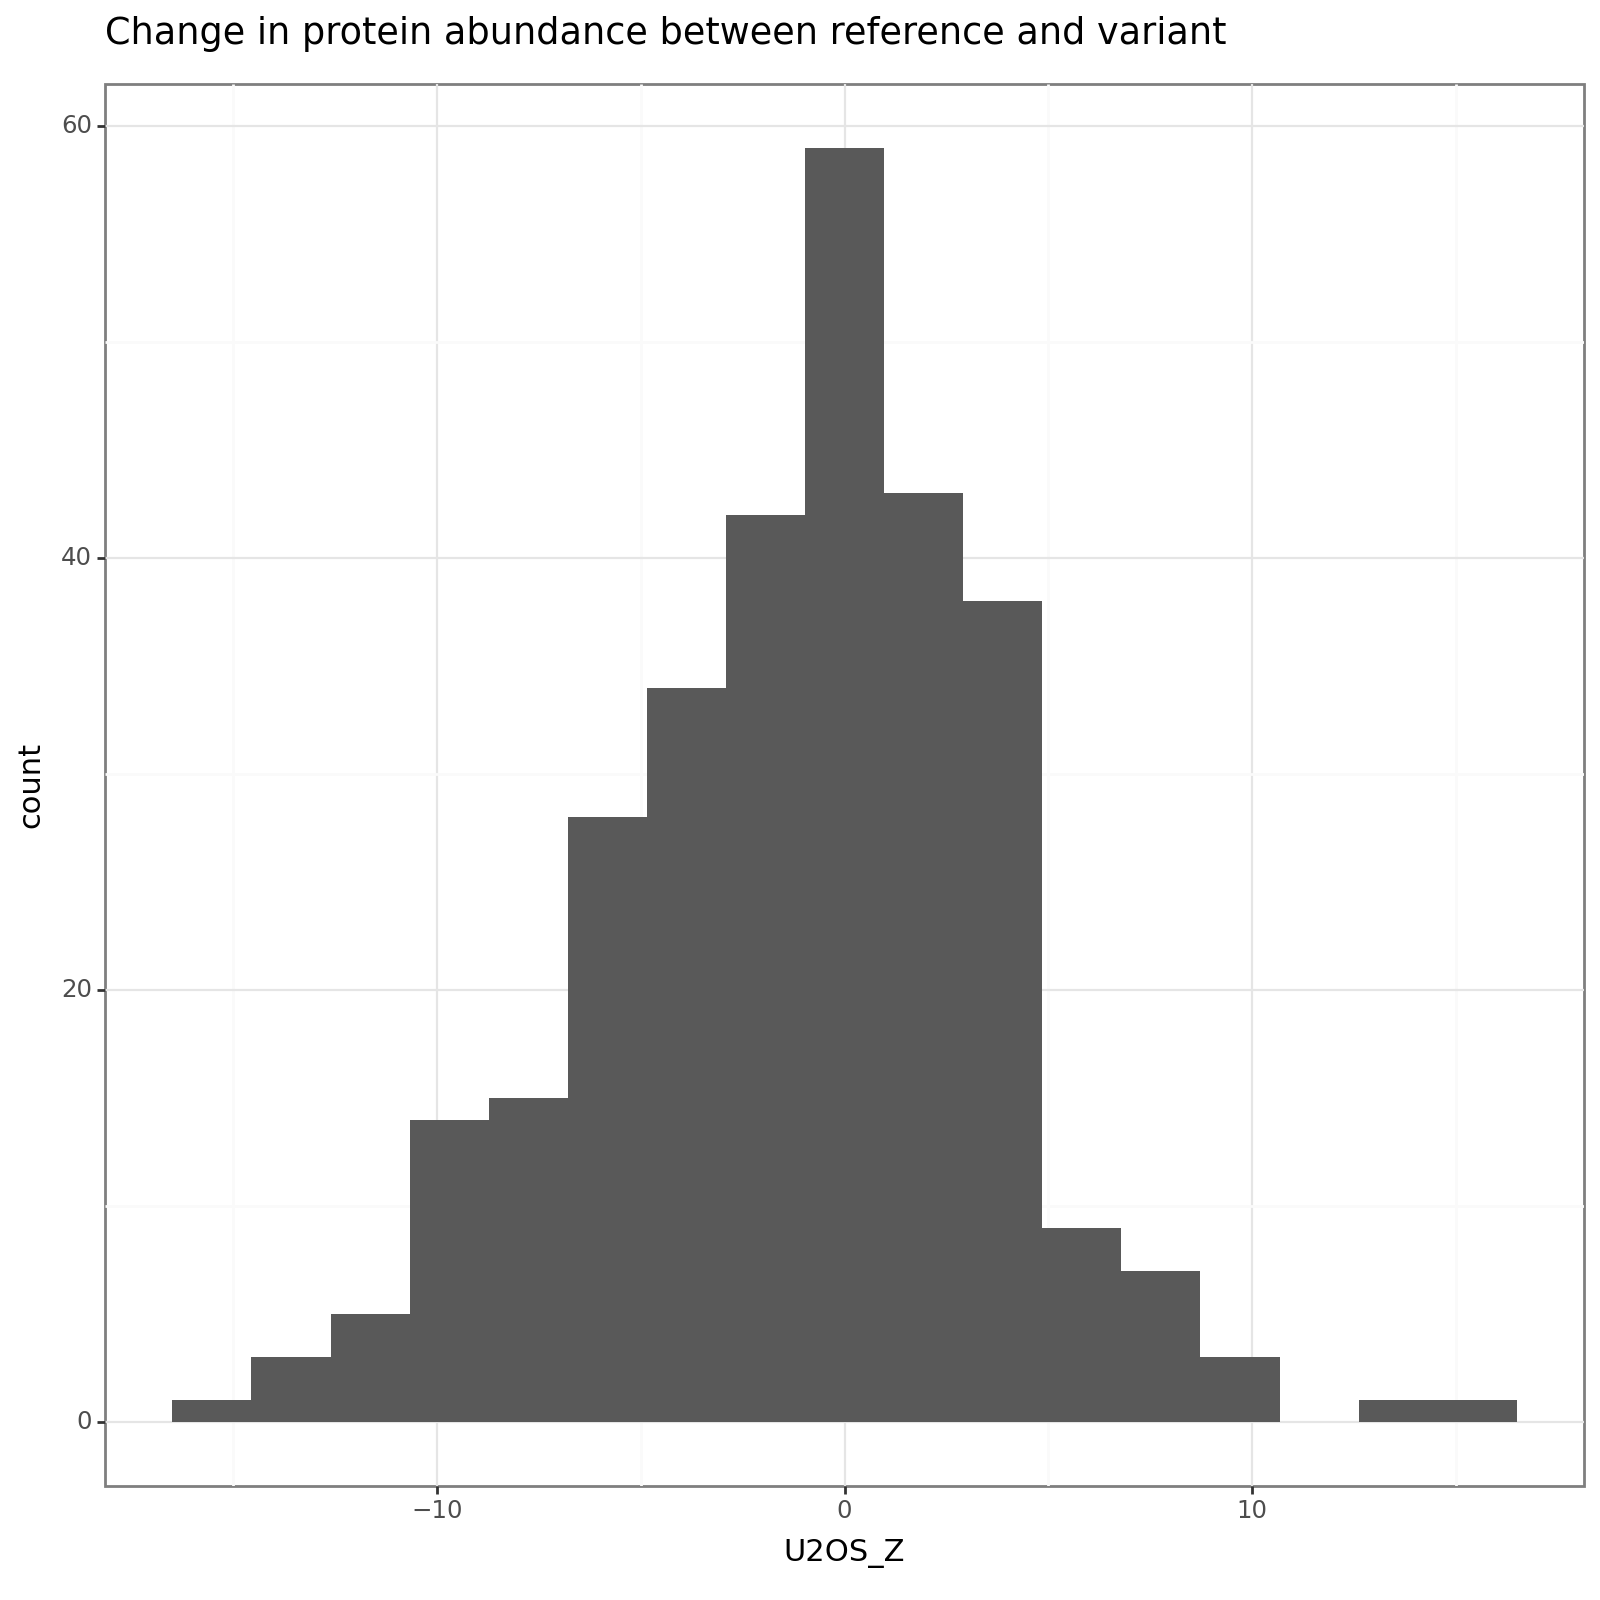

In [20]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_well,
        aes(x="U2OS_Z"),
    )
    + geom_histogram()
    + theme_bw()
    + labs(title="Change in protein abundance between reference and variant")
)
print(plot1)

## Analyze wrt clinvar annotations

In [12]:
well_abun_stats = pl.read_csv("../results/well_abundance_changes.csv")

clinvar = pl.read_csv("../data/allele_collection_clinical_significance.csv")
clinvar = clinvar.with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
).select(["Variant", "clinvar_cs"]).with_columns(
    pl.when(pl.col("clinvar_cs").is_not_null()).then("clinvar_cs").otherwise(pl.lit("not provided")).alias("clinvar_cs")
)

well_abun_stats = well_abun_stats.join(clinvar, on="Variant")

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.


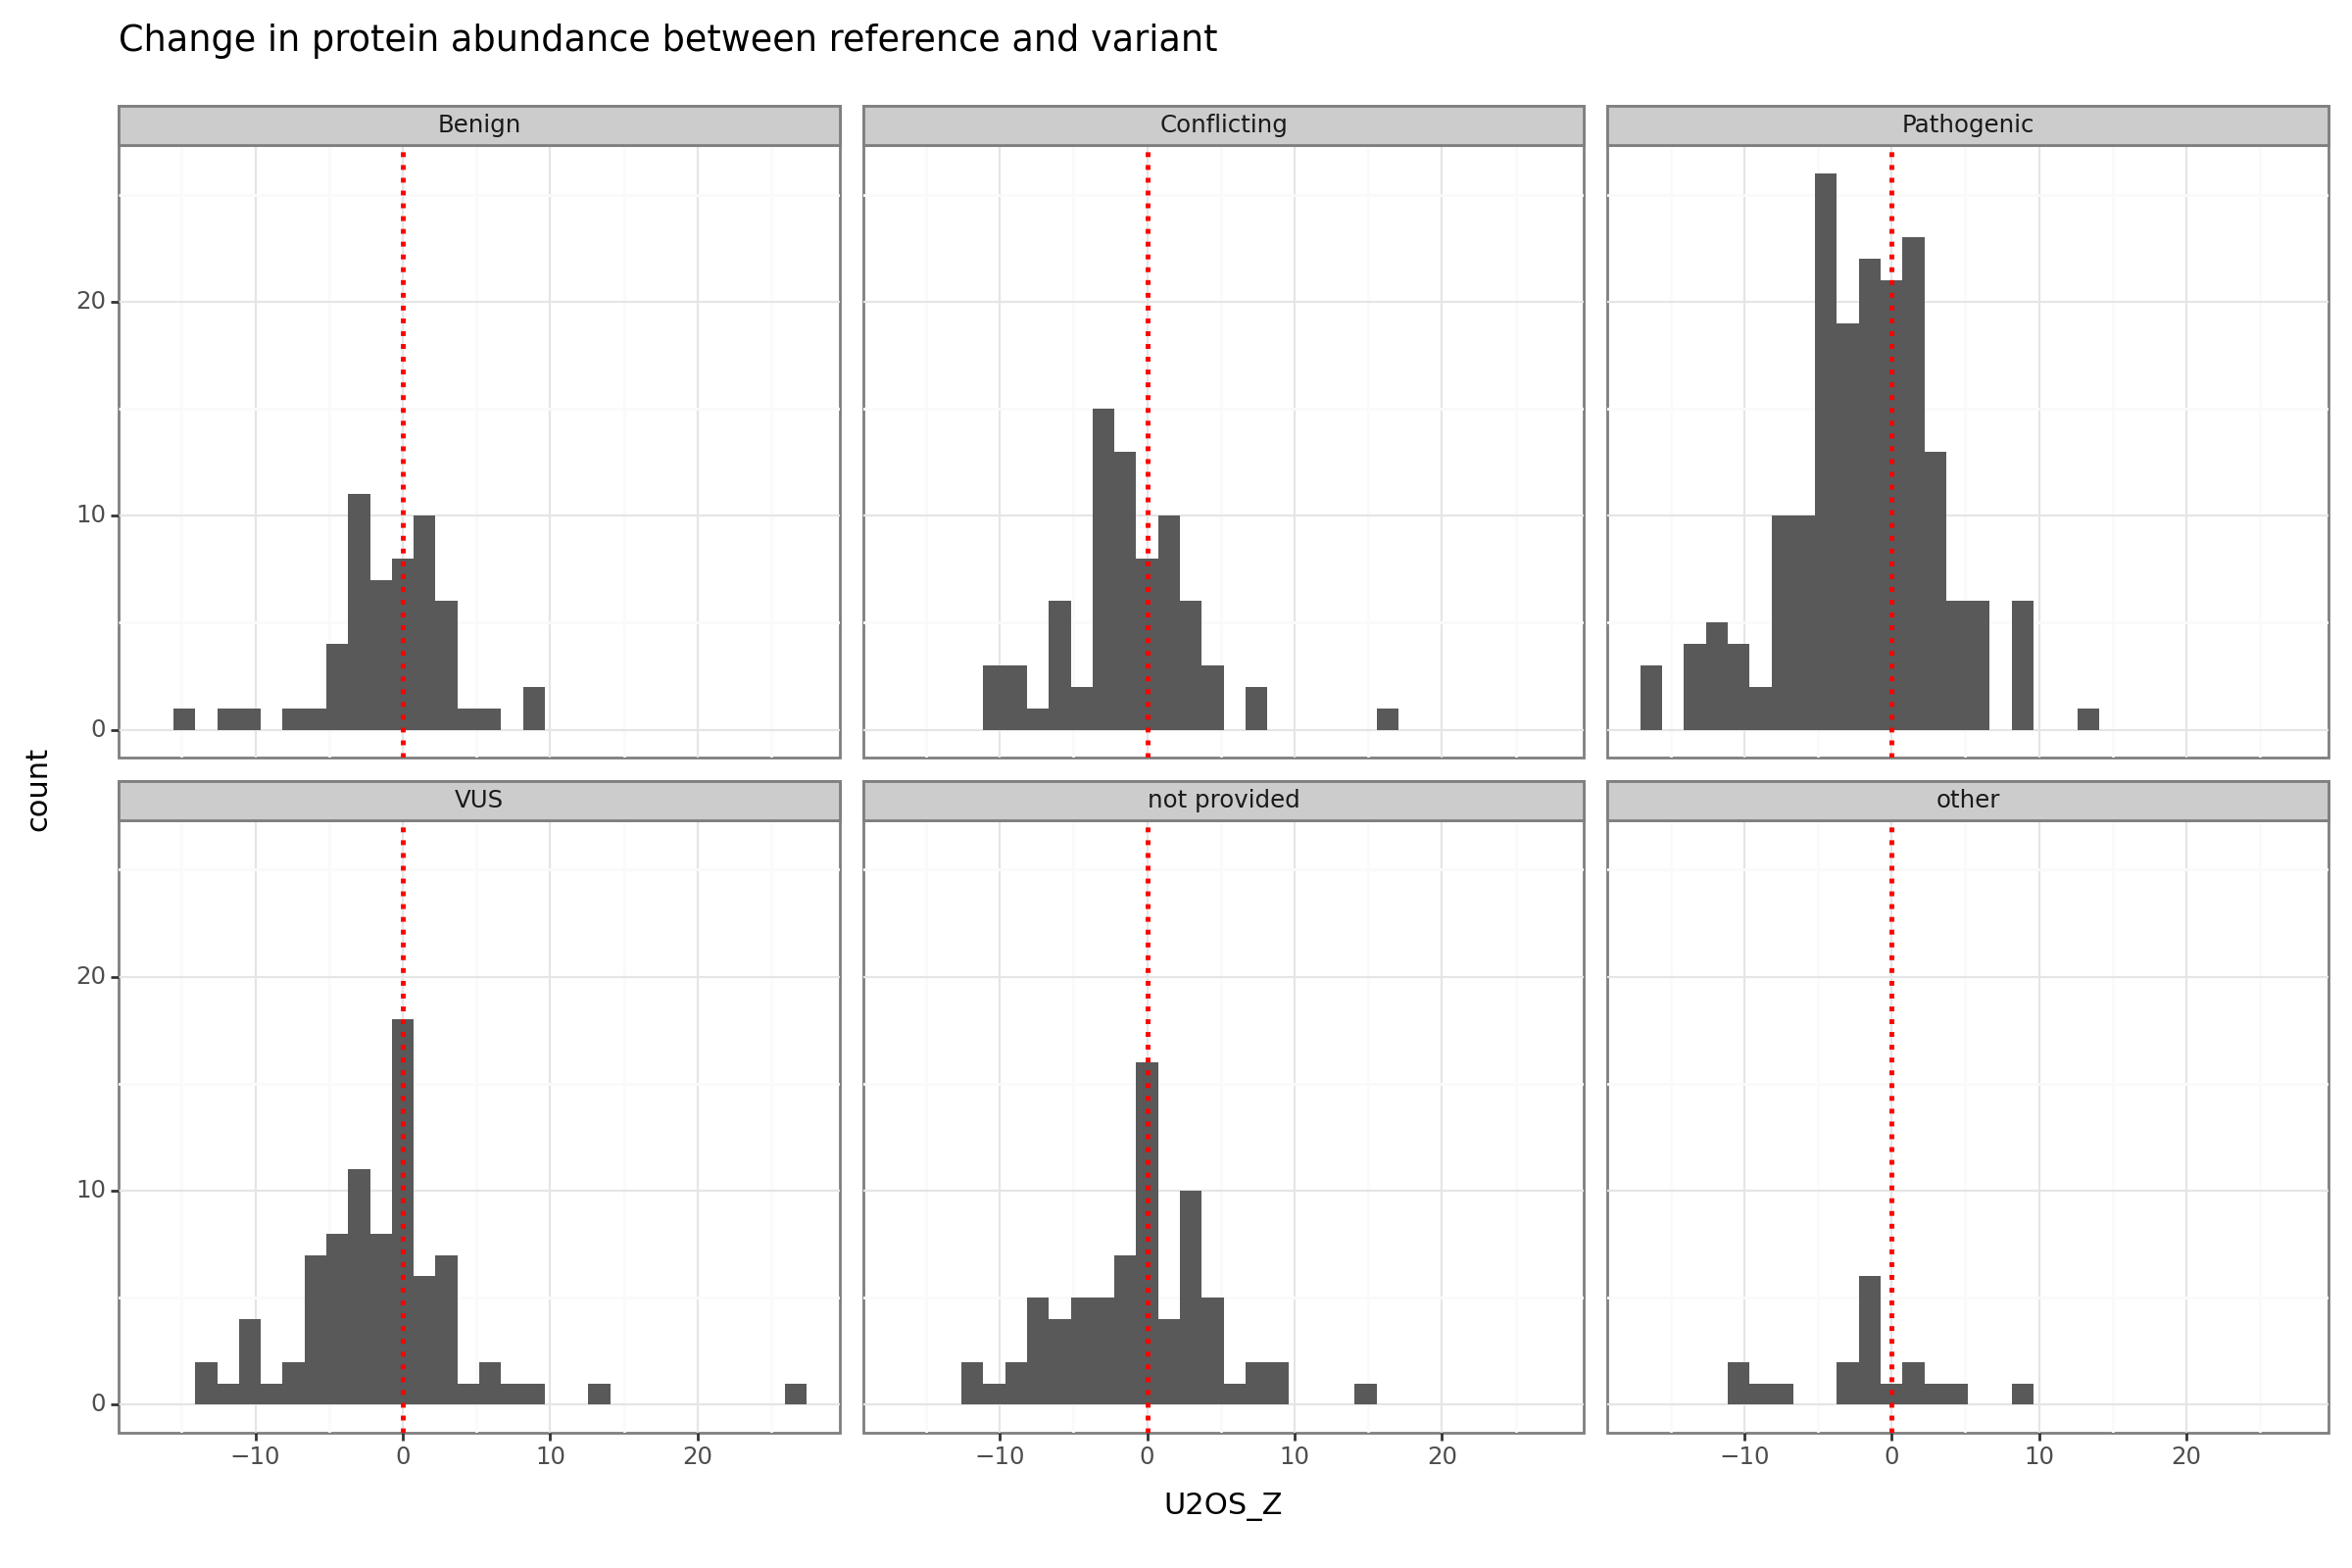

In [17]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs, facet_wrap, geom_vline

plotnine.options.figure_size = (12, 8)
plot1 = (
    ggplot(
        well_abun_stats,
        aes(x="U2OS_Z"),
    )
    + geom_histogram()
    + facet_wrap("clinvar_cs")
    + geom_vline(xintercept=0, color="red", linetype="dotted", size=1)
    + theme_bw()
    + labs(title="Change in protein abundance stratefied by clinvar")
)
print(plot1)

## Compare USO2 to DUAL using raw values

Discussion of columns in this dataset:

- avg_gfp: average GFP signal (actual protein abundance level)
- avg_mcherry: average mCherry signal (overexpression level)
- avg_GFP_mCherry_ratio: abundance:expression - this should give a measure of stability
- valid_well: did the well pass various QA/QC thresholds?
    - 800 cells with mCherry > 500 (similar to imaging selection agent + cell count filter)
    - avg reference GFP > 100
- valid_gfp_mcherry_ratio: I don't know how this is different from 'valid_well'

Analysis questions
- what is the correlation between U2OS GFP intensity versus avg_GFP?
    - Do not compare z-stats ... would have to re-compute z-stats using only avg_GFP and not avg_GFP_mCherry_ratio
    - Try for all, valid_well, and valid_gfp_mcherry_ratio
    - Compute median value across all batches (imaging) and mut_id (DUAL)

In [22]:
# Get meta features
b7_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)
b8_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)

cell_alleles = pl.concat([b7_alleles.collect(), b8_alleles.collect()])

In [26]:
b7_prof = pl.scan_parquet(
    f"{prof_dir}/2024_01_23_Batch_7/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)
b8_prof = pl.scan_parquet(
    f"{prof_dir}/2024_02_06_Batch_8/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)

In [39]:
# Take median
gfp_int = pl.concat([
    b7_prof.select(["Metadata_CellID", "Cells_Intensity_MedianIntensity_GFP"]).collect(),
    b8_prof.select(["Metadata_CellID", "Cells_Intensity_MedianIntensity_GFP"]).collect(),
])

gfp_int = cell_alleles.join(gfp_int, on="Metadata_CellID", how="left")

gfp_int = gfp_int.group_by("Metadata_gene_allele").agg(
    pl.mean("Cells_Intensity_MedianIntensity_GFP").alias("Mean_GFP_Intensity")
)

In [43]:
dual_stats.head()

avg_gfp,avg_mcherry,avg_GFP_mCherry_ratio,pla,well,coordinates,n_cells,orf_id,mut_id,node_type,nt_change,aa_change,clinical_significance,symbol,valid_well,z_pdest_empty,z_pdest_gfp,valid_gfp_mcherry_ratio,Metadata_gene_allele
f64,f64,f64,i64,str,str,i64,i64,i64,str,str,str,str,str,bool,f64,f64,bool,str
165.854793,3813.039428,0.080033,24,"""E10""","""(24, 'E10')""",10882,55247,0,"""wt""","""WT""","""WT""","""WT""","""OAS1""",true,3.709554,-0.493237,true,"""OAS1"""
38.548163,7812.079547,0.010358,24,"""B07""","""(24, 'B07')""",8786,52920,2670,"""allele""","""388G>A""","""Gly130Ser""","""VUS""","""LITAF""",true,-0.114591,-0.709508,null,"""LITAF_Gly130Se…"
651.596799,4750.119233,0.214581,8,"""A10""","""(8, 'A10')""",9387,3020,214471,"""allele""","""937G>A""","""Glu313Lys""","""Pathogenic""","""CHN1""",true,11.094285,-0.075601,null,"""CHN1_Glu313Lys…"
1732.782852,6722.060197,0.365943,9,"""F01""","""(9, 'F01')""",8908,13113,21930,"""allele""","""427C>T""","""Arg143Cys""","""Conflicting""","""MCEE""",true,19.401841,0.394226,null,"""MCEE_Arg143Cys…"
115.877999,13589.93972,0.055213,18,"""A10""","""(18, 'A10')""",25,3438,0,"""wt""","""WT""","""WT""","""WT""","""TMEM43""",false,2.347301,-0.570278,false,"""TMEM43"""


In [51]:
dual_stats = pl.read_csv("../results/pDEST_DUAL_avg.tsv", separator="\t")
dual_stats = dual_stats.with_columns(
    pl.when(pl.col("aa_change") == "WT").then("symbol").otherwise(
        pl.concat_str(["symbol", "aa_change"], separator="_")
    ).alias("Metadata_gene_allele")
)

dual_stats_nofilt = dual_stats.group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

dual_stats_wellfilt = dual_stats.filter(pl.col("valid_well") == True).group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

dual_stats_ratiofilt = dual_stats.filter(pl.col("valid_gfp_mcherry_ratio") == True).group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

In [52]:
gfp_int_nofilt = gfp_int.join(dual_stats_nofilt, on="Metadata_gene_allele")
gfp_int_wellfilt = gfp_int.join(dual_stats_wellfilt, on="Metadata_gene_allele")
gfp_int_ratiofilt = gfp_int.join(dual_stats_ratiofilt, on="Metadata_gene_allele")

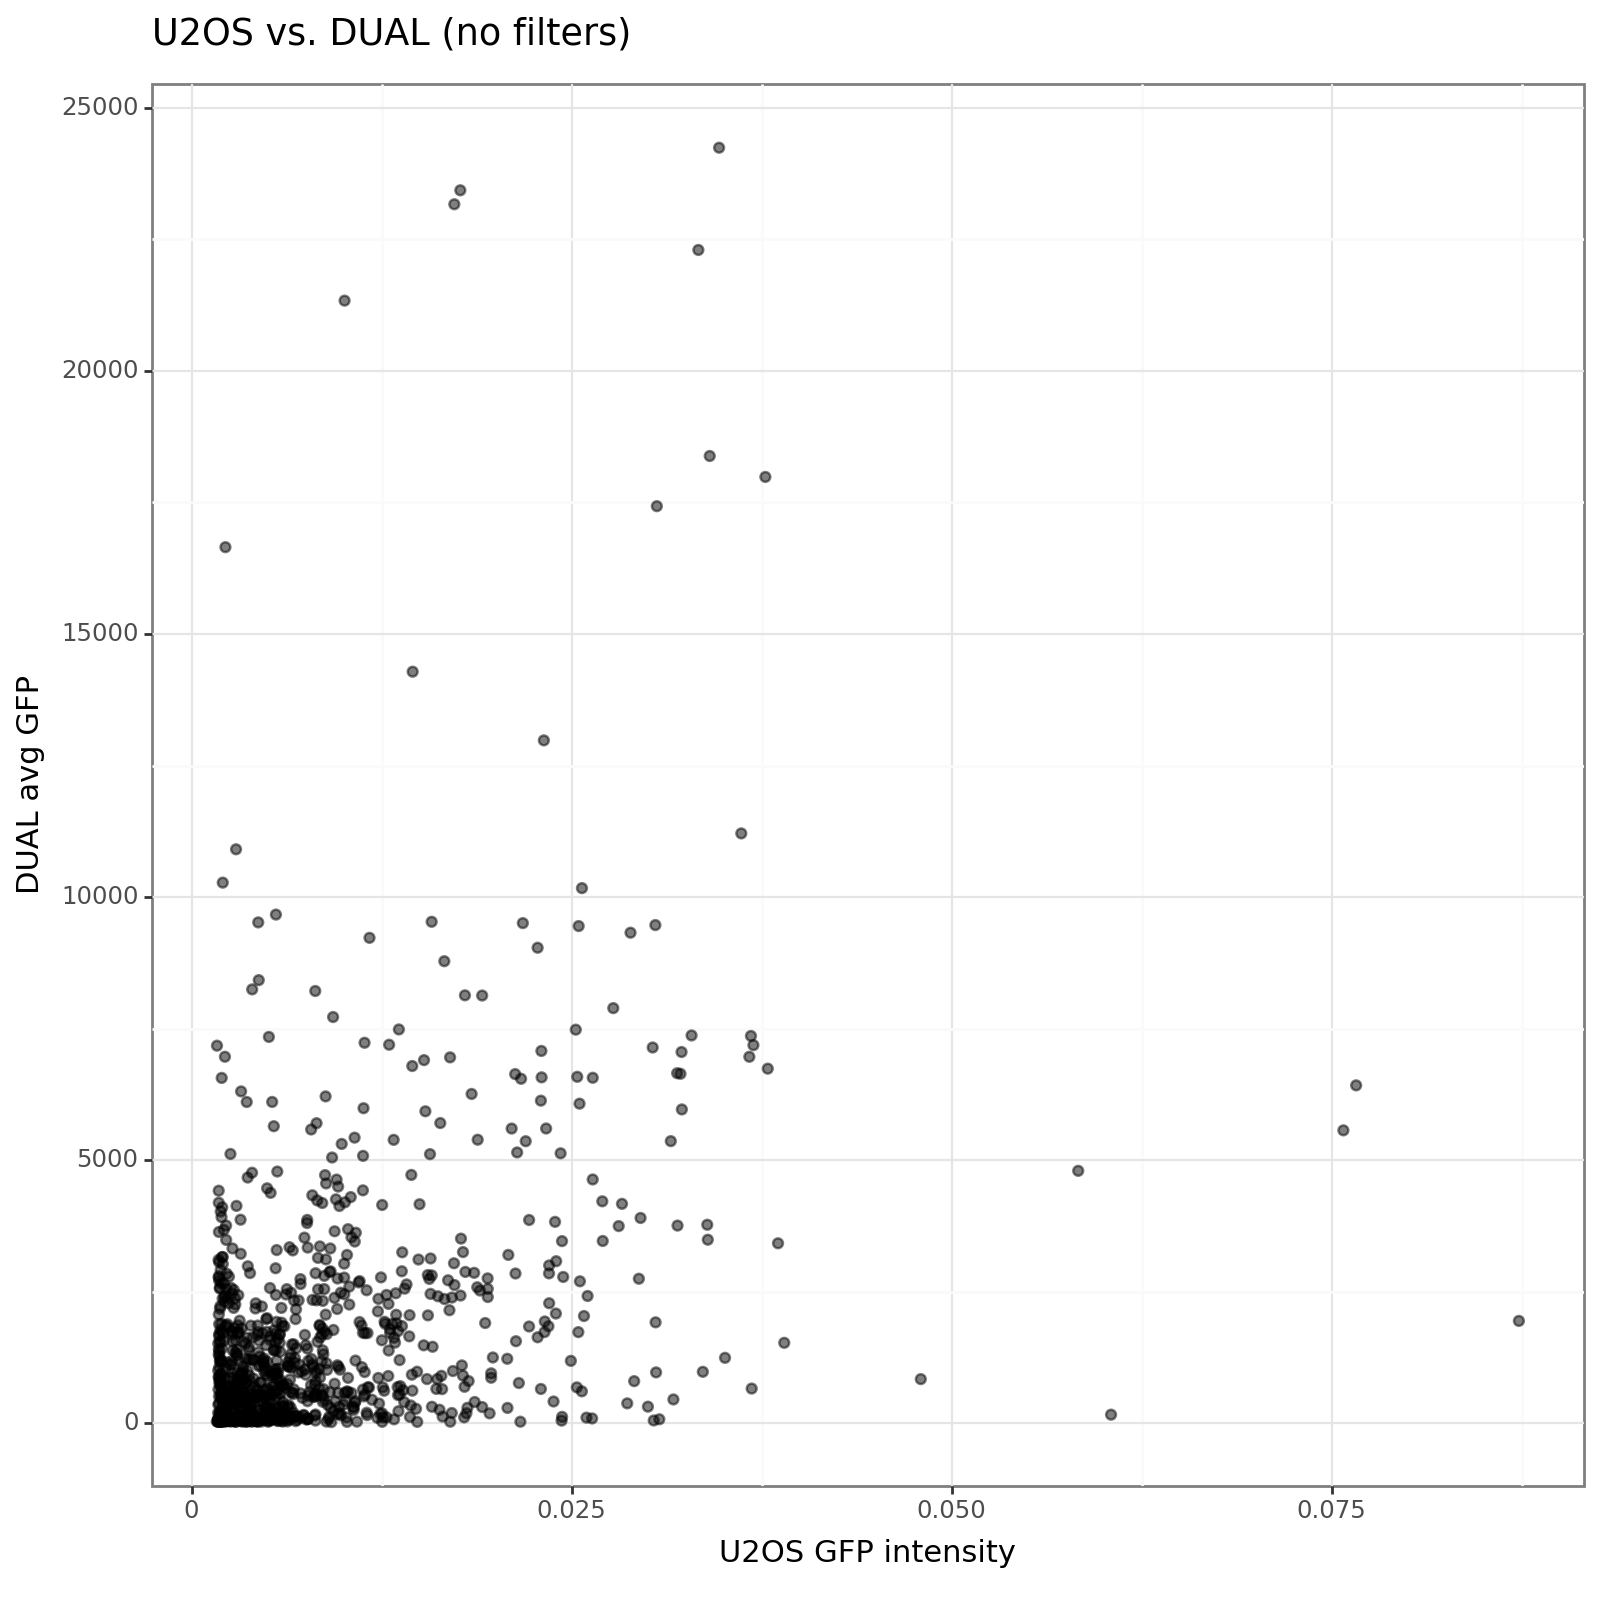

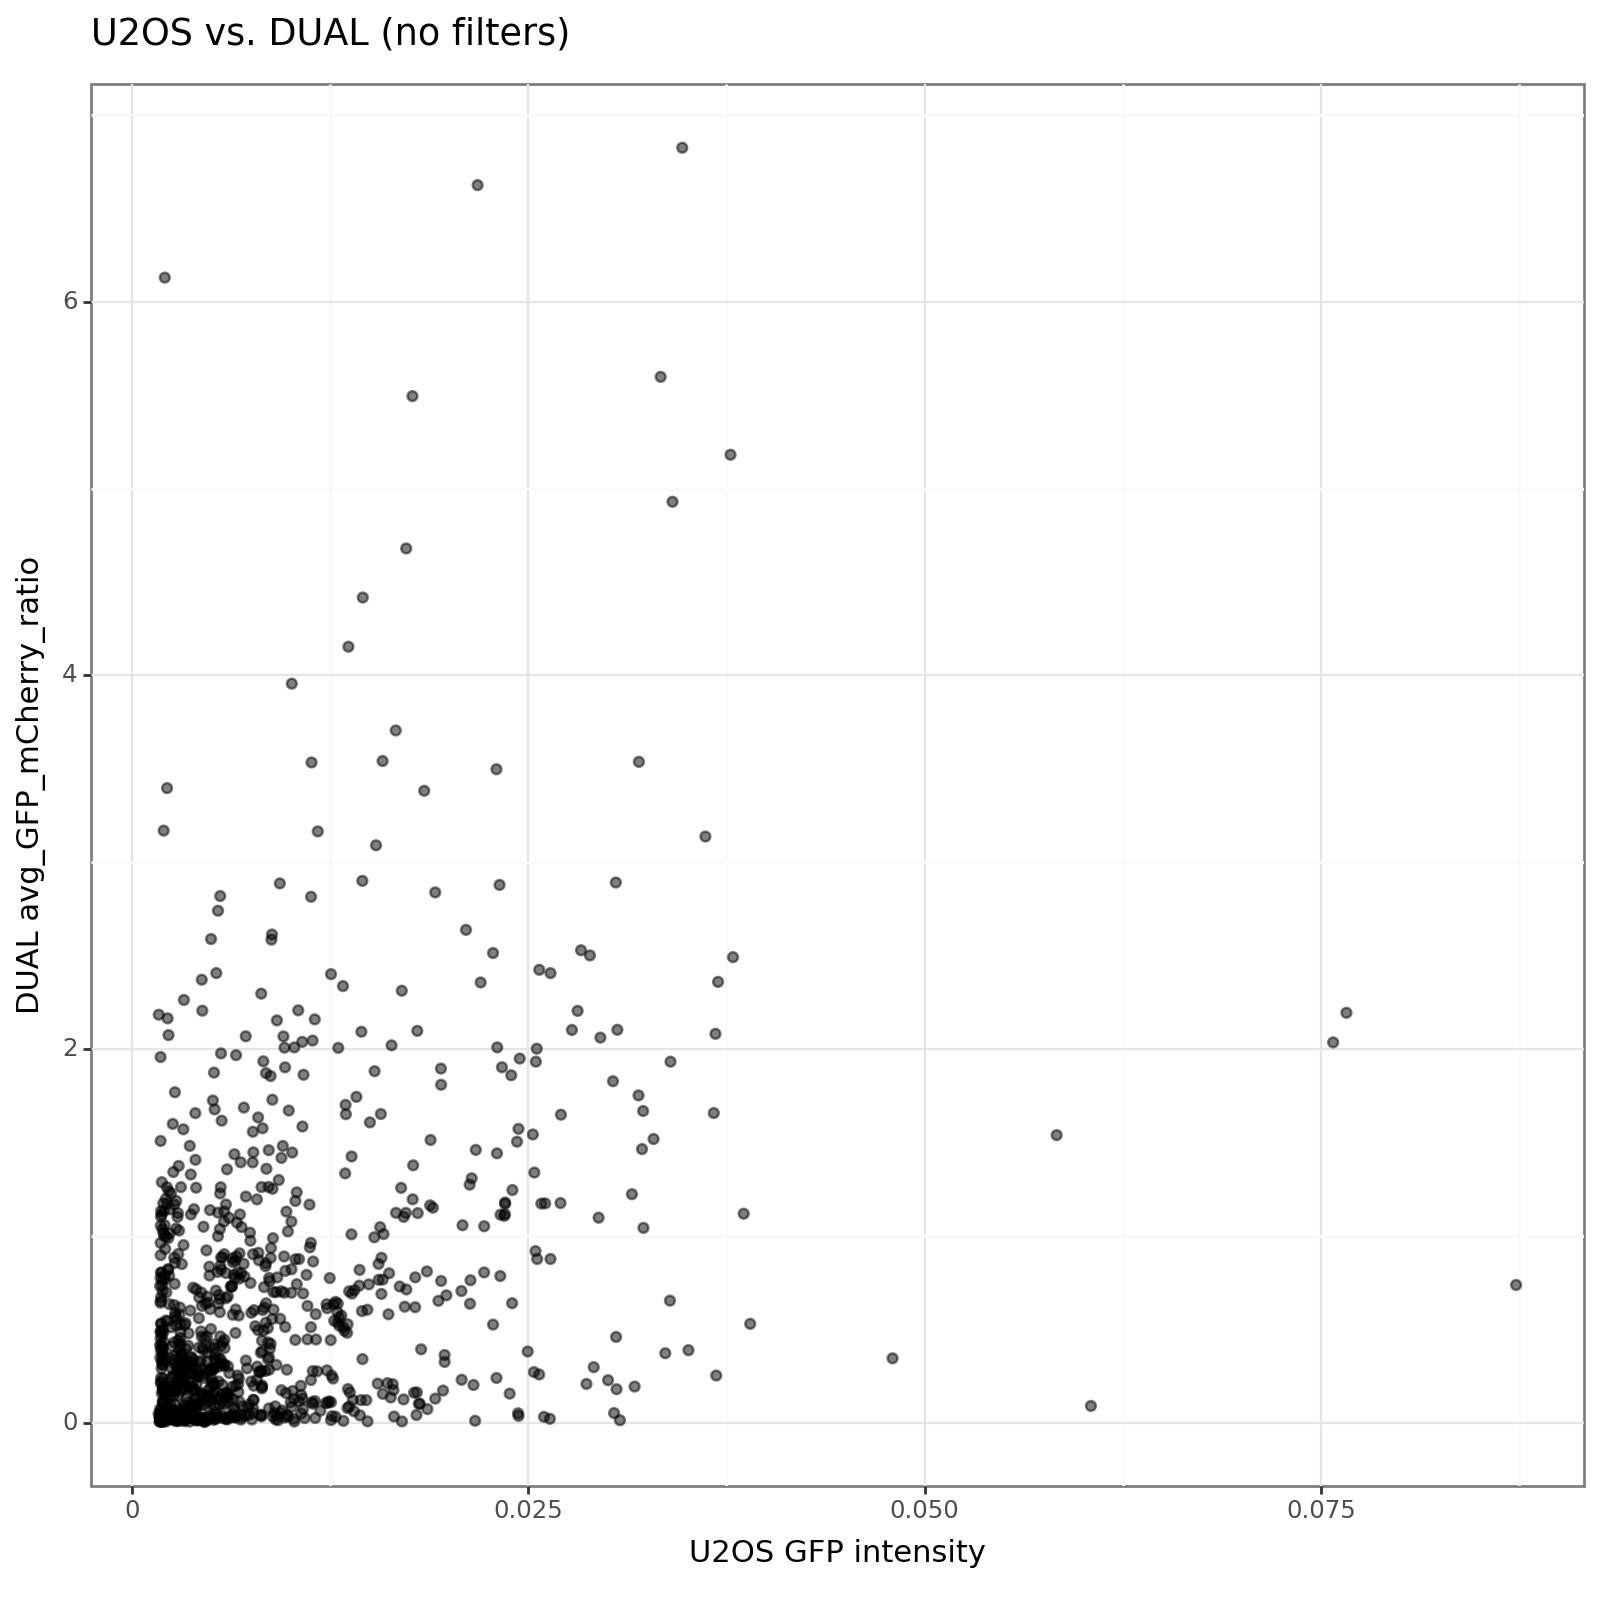

In [49]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_nofilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (no filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_nofilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (no filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

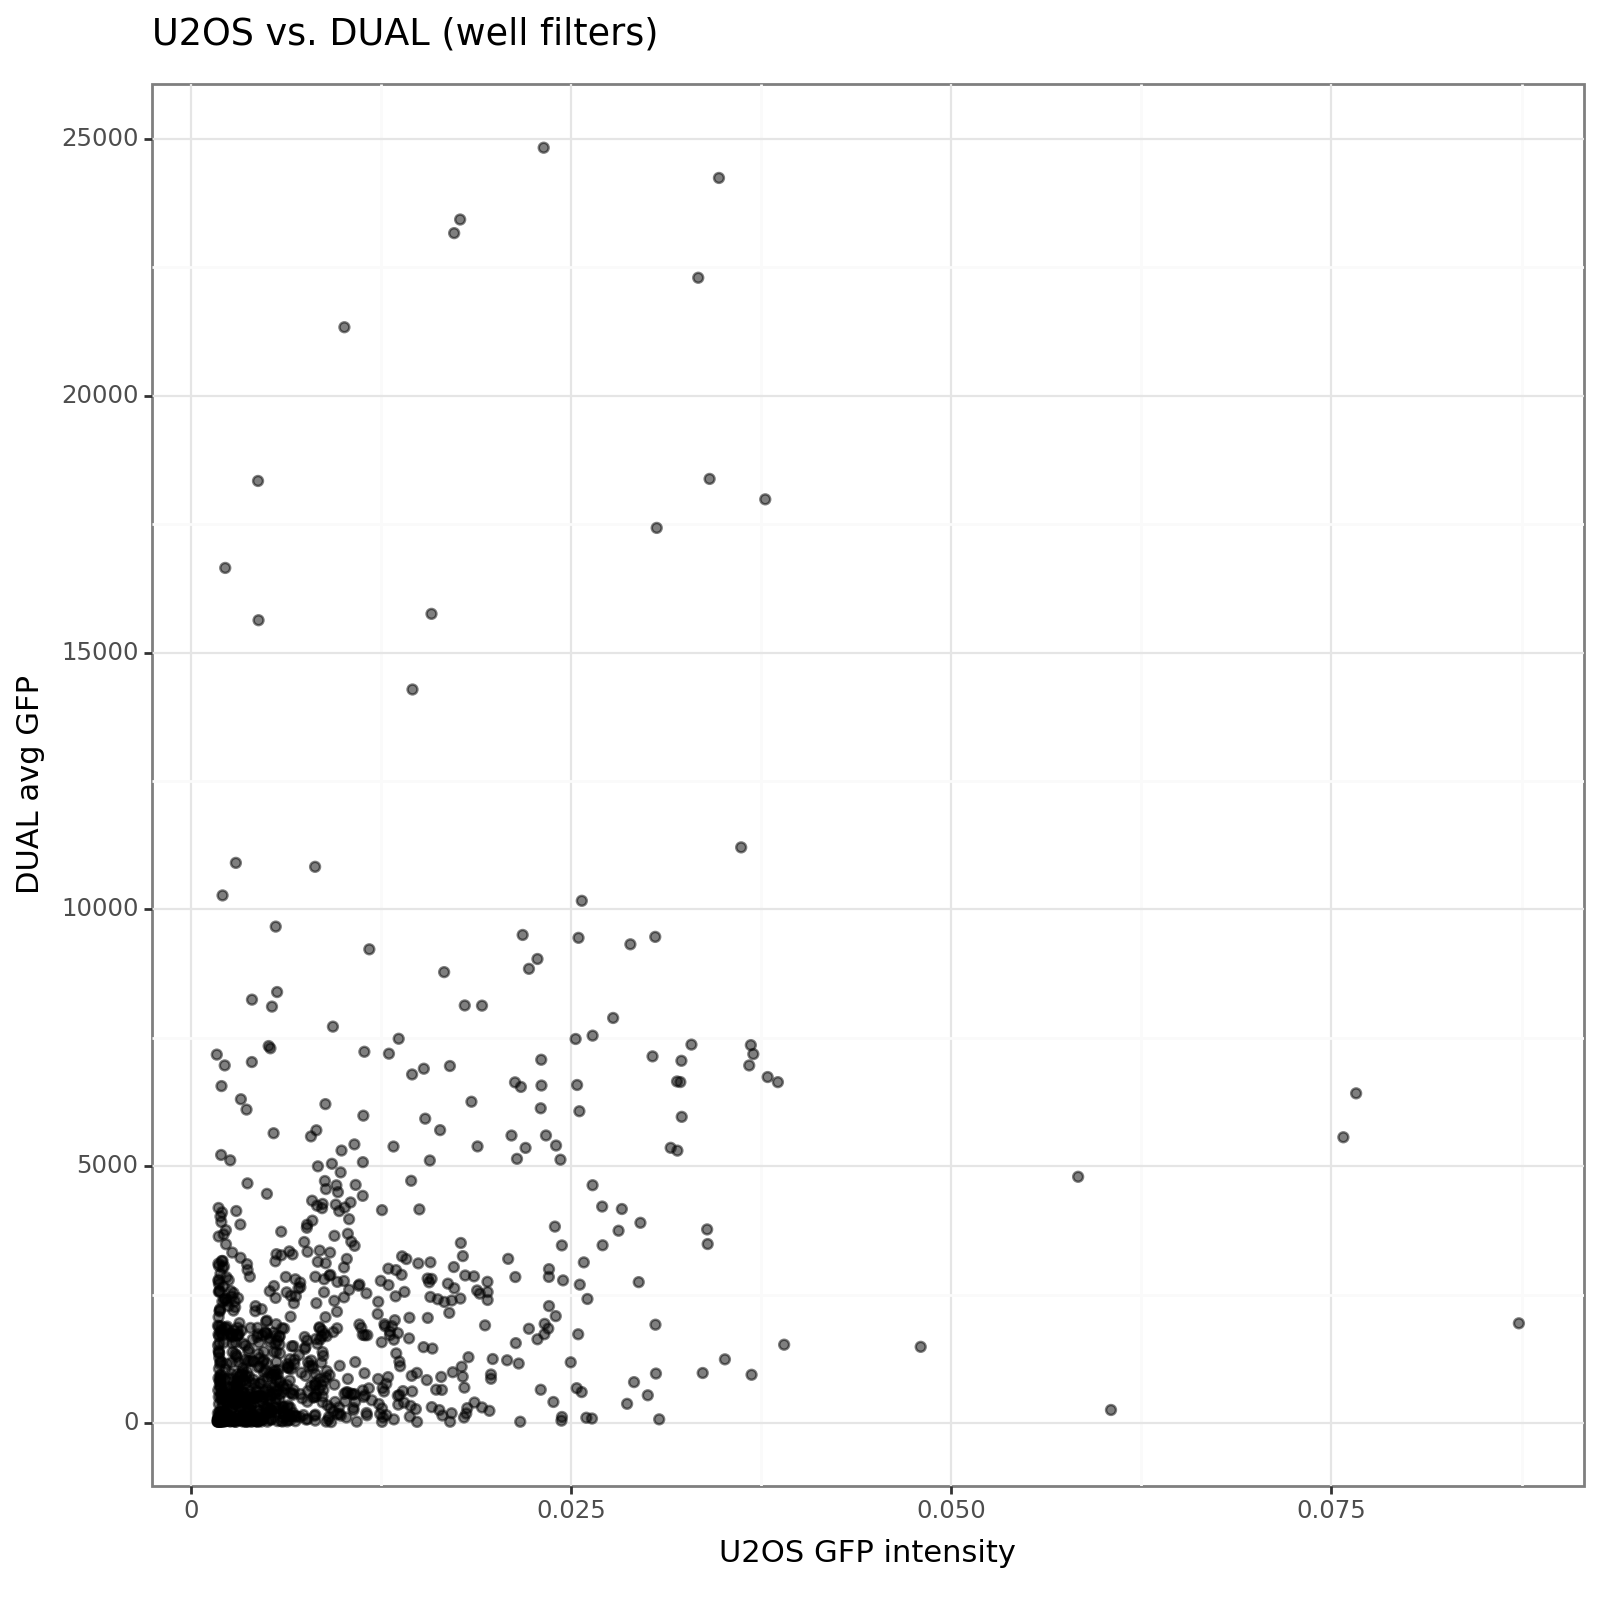

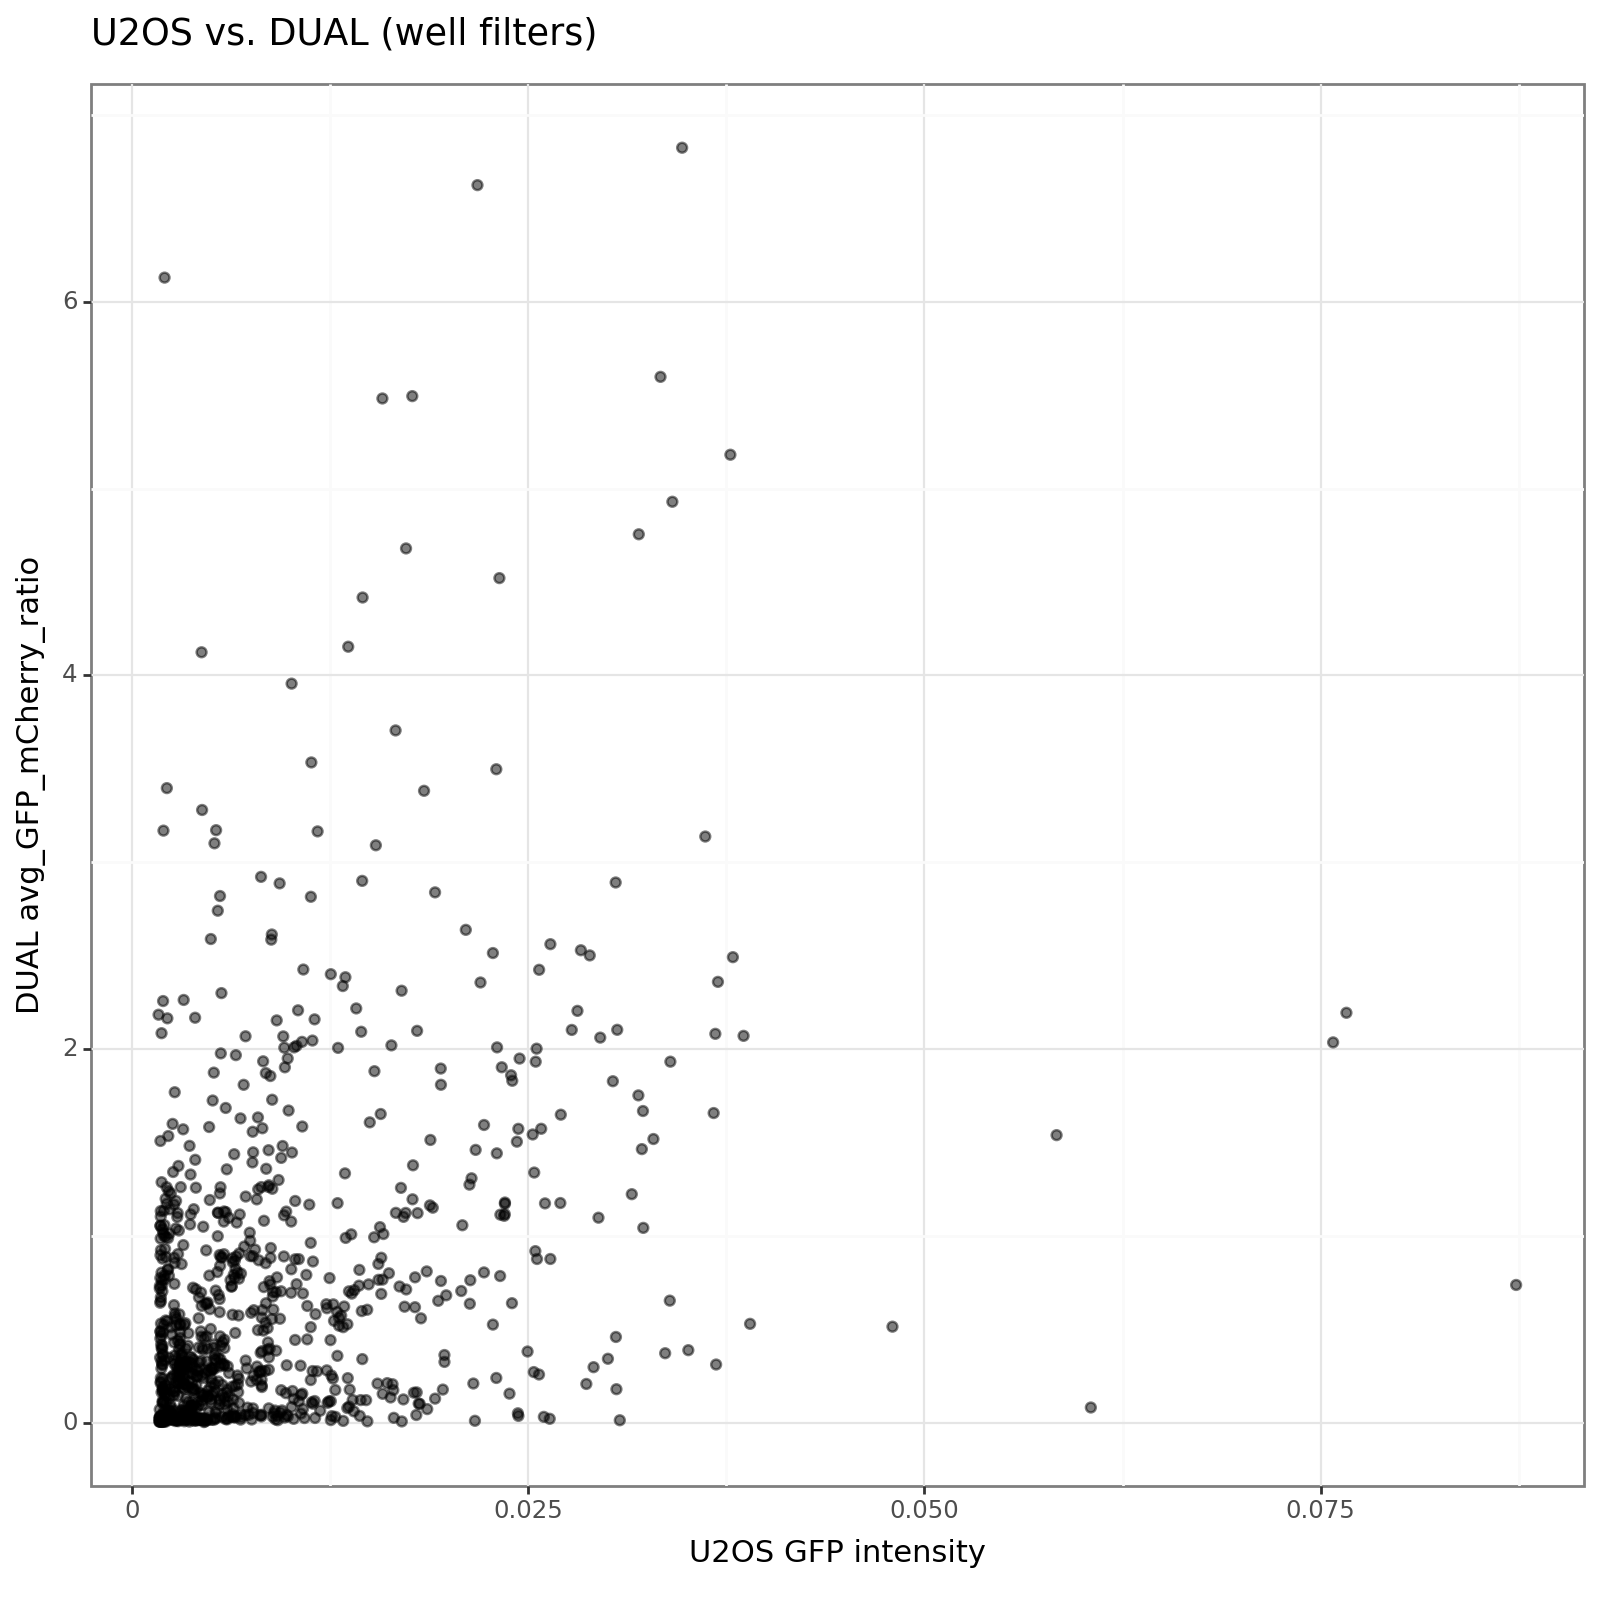

In [53]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_wellfilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (well filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_wellfilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (well filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

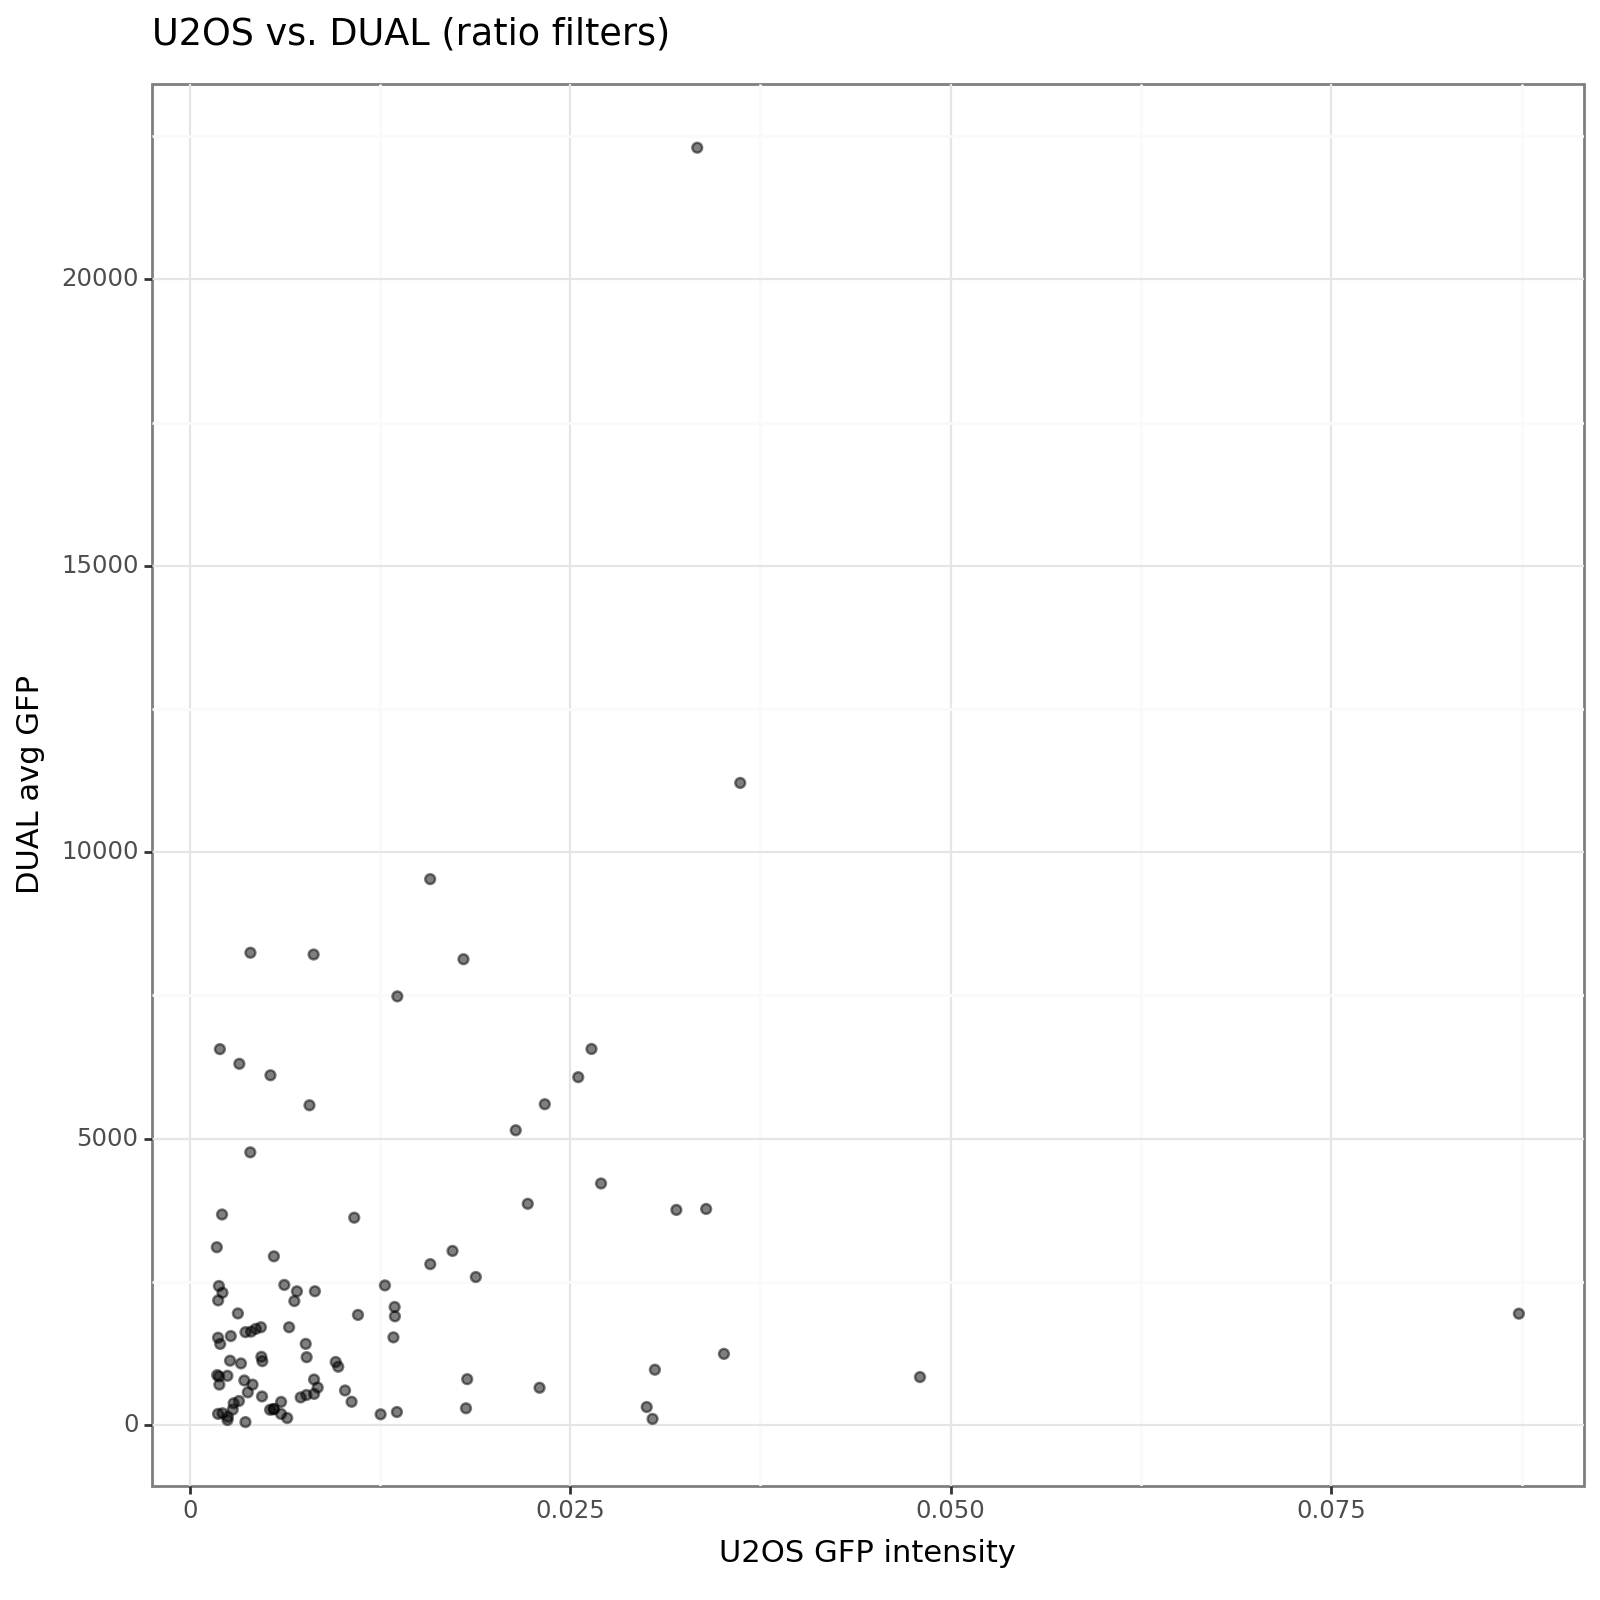

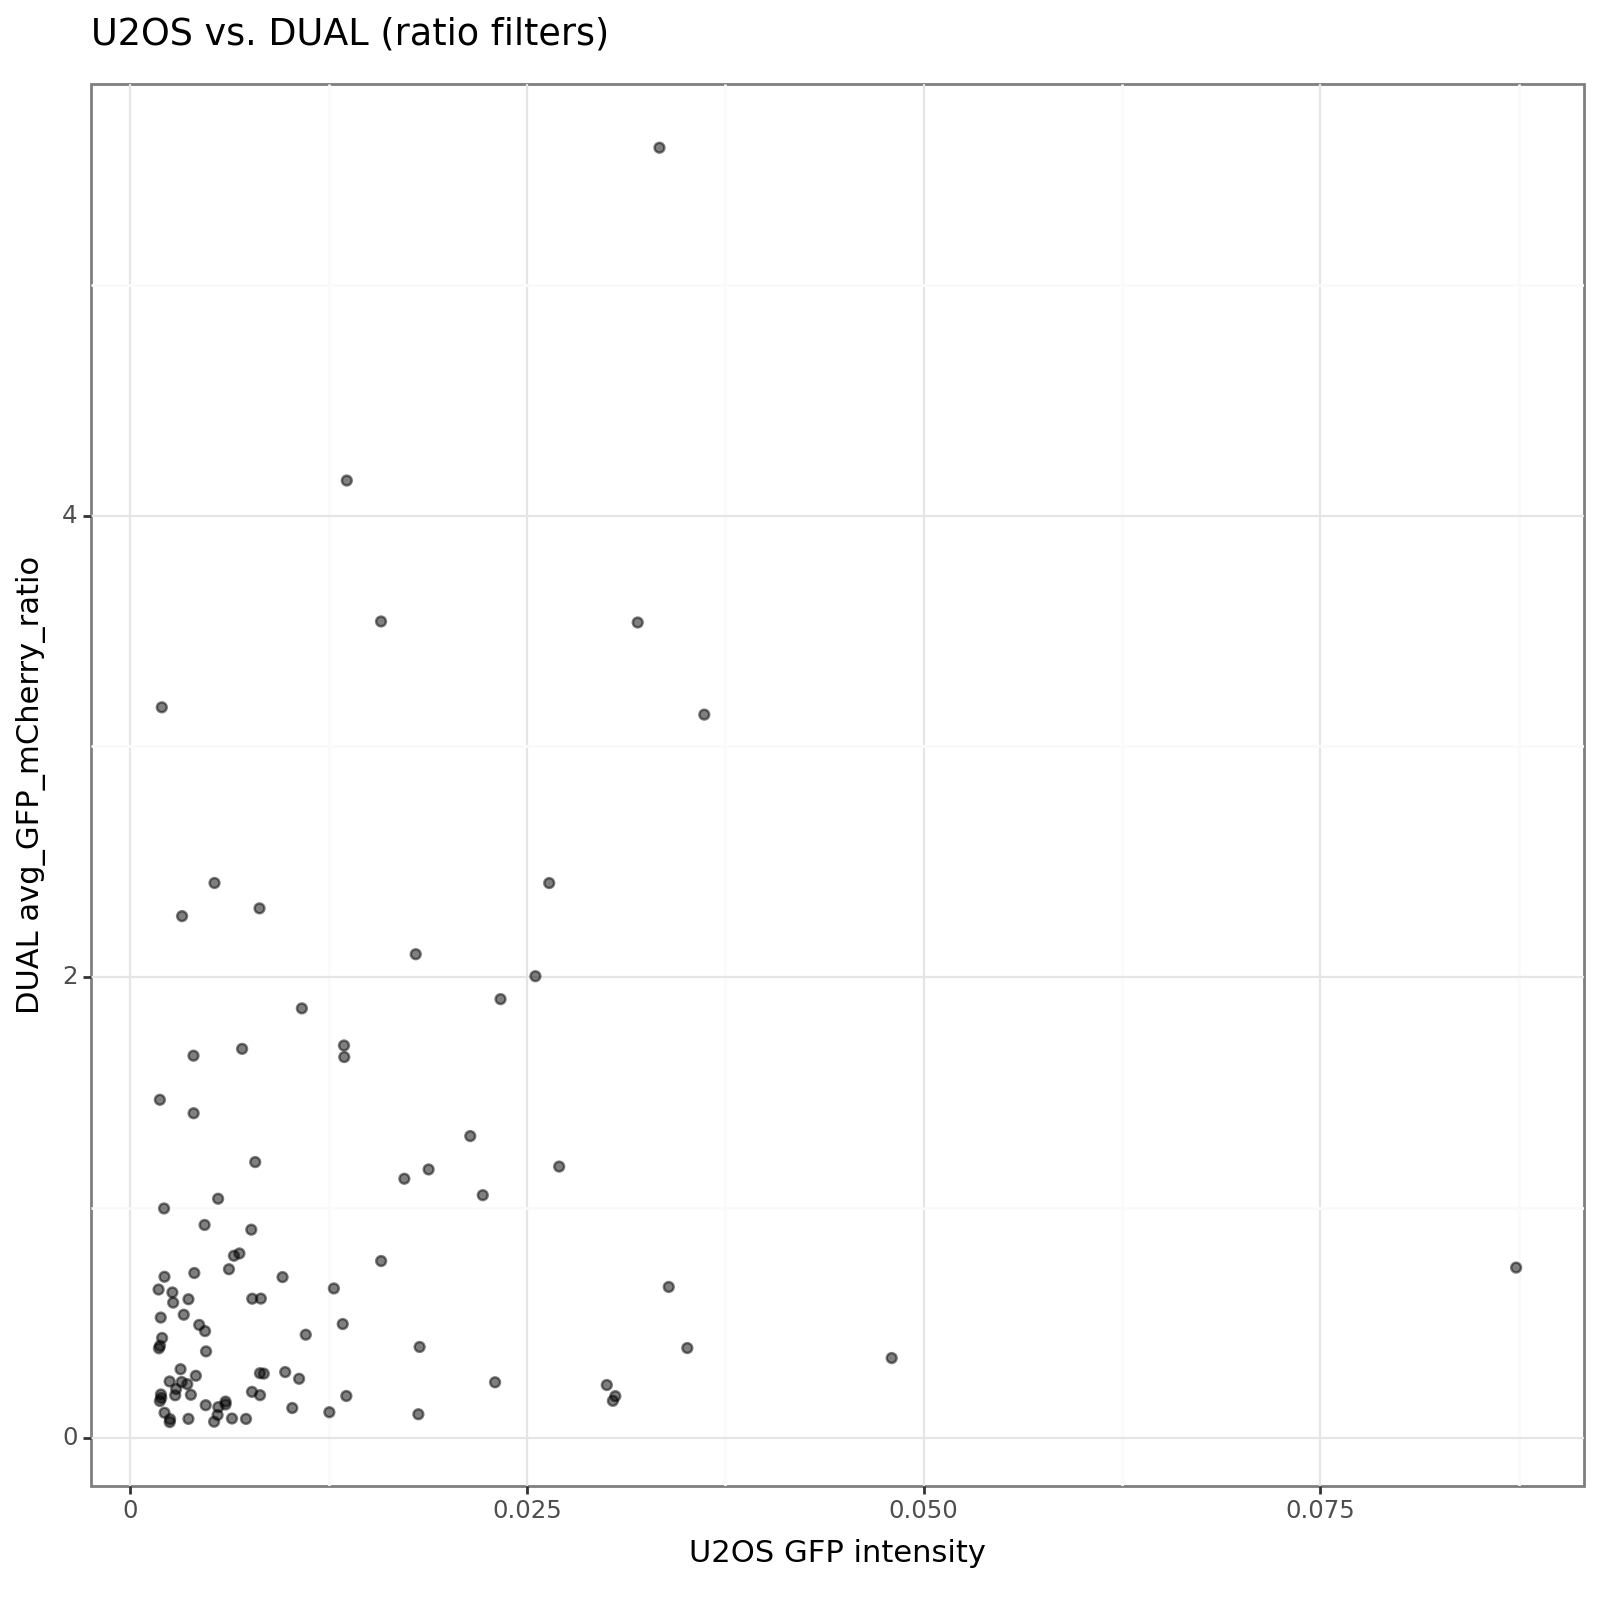

In [54]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_ratiofilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (ratio filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_ratiofilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (ratio filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

Conclusions:
- I see no correlation between raw GFP intensity between assays
- Using GFP:mCherry ratio from DUAL does not help
- Filtering the DUAL data by various criteria does not help

Next steps: get Z-stats computed from just the avg_gfp values, not from the gfp:mCherry ratios.